In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from datetime import datetime
import time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_model_metrics(test_data, model, model_name):
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [3]:
# Set the path to your data folders
data_folder = "../../../Data/PESO/cropped_images"
train_folder = os.path.join(data_folder, "cropped_train")
test_folder = os.path.join(data_folder, "cropped_test")
validation_folder = os.path.join(data_folder, "cropped_validation")

# Extract GLCM features

In [4]:
def extract_features(image_path):
    image = cv2.imread(image_path, 0)  # Read the image in grayscale
    
    try:
        resized_img = cv2.resize(image, (128, 64))
    except:
        resized_img = image
    
    props = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

    glcm = graycomatrix(resized_img, 
                        distances=[1], 
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        levels=256,
                        symmetric=True, 
                        normed=True)
    features = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
        features.append(item)
    
    return features

# Load and preprocess data
def load_data(folder):
    data = []
    labels = []
    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    features = extract_features(image_path)
                    data.append(features)
                    labels.append(subfolder)  # Assuming subfolder names are class labels
                except:
                    continue

    return np.array(data), labels

# Load training and validation data
X_train, y_train = load_data(train_folder)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [6]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

In [7]:
# Extract class weights
from sklearn.utils.class_weight import compute_class_weight

# Convert the labels to a NumPy array
labels = np.array(y_train)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
#class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))

#new_labels = {'healthy': 0, 'unhealthy': 1}

# Create a new dictionary with the renamed keys
#class_weights = {new_labels[key]: value for key, value in class_weights_dict.items()}

In [8]:
class_weights_dict

{0: 0.048648648648648596, 1: 0.9513513513513514}

In [9]:
sample_weights = [class_weights[label] for label in y_train]

# SVC

In [10]:
model_name = 'LBW_GLCM_SVC'

In [11]:
# Train a classifier (SVM in this case)
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

SVC(class_weight={0: 0.048648648648648596, 1: 0.9513513513513514},
    kernel='linear', probability=True, random_state=42)

Best threshold: 0.05 with F1-score: 0.14


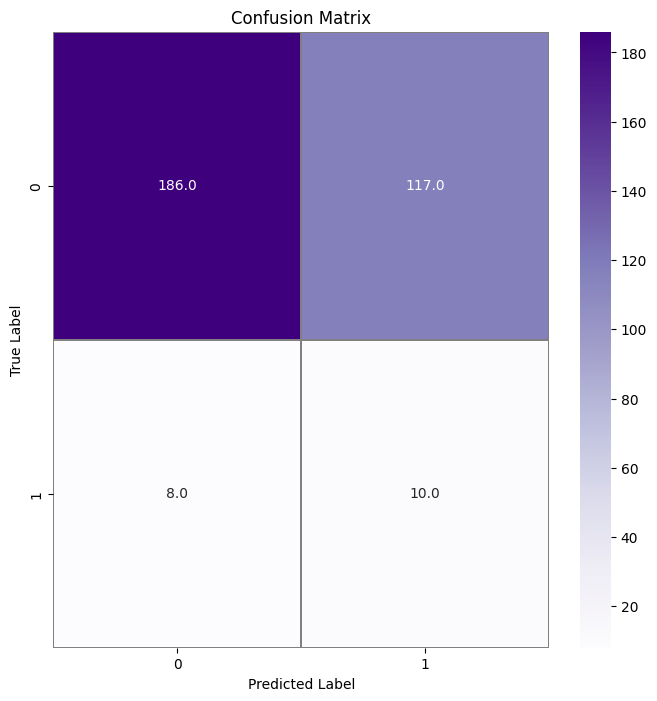

              precision    recall  f1-score   support

           0       0.96      0.61      0.75       303
           1       0.08      0.56      0.14        18

    accuracy                           0.61       321
   macro avg       0.52      0.58      0.44       321
weighted avg       0.91      0.61      0.71       321

     Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  LBW_GLCM_SVC  0.6                     0.14      0.61         0.56  \

   Specificity   PPV   NPV   PLR   NLR  
0         0.61  0.08  0.96  1.44  0.72  


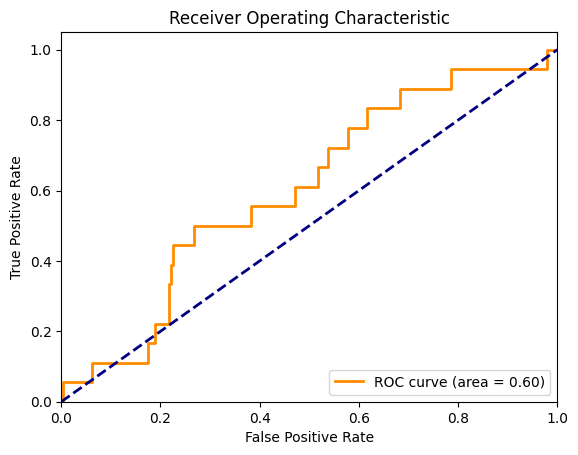

In [12]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name=model_name)

# XGBOOST

In [13]:
model_name = 'LBW_GLCM_XGBOOST'

In [14]:
# computing class weights for xgboost
class_counts = np.bincount(y_train)
imbalance_ratio = class_counts[0] / class_counts[1]

In [15]:
classifier = xgb.XGBClassifier(random_state=42, scale_pos_weight=imbalance_ratio)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Best threshold: 0.00 with F1-score: 0.11


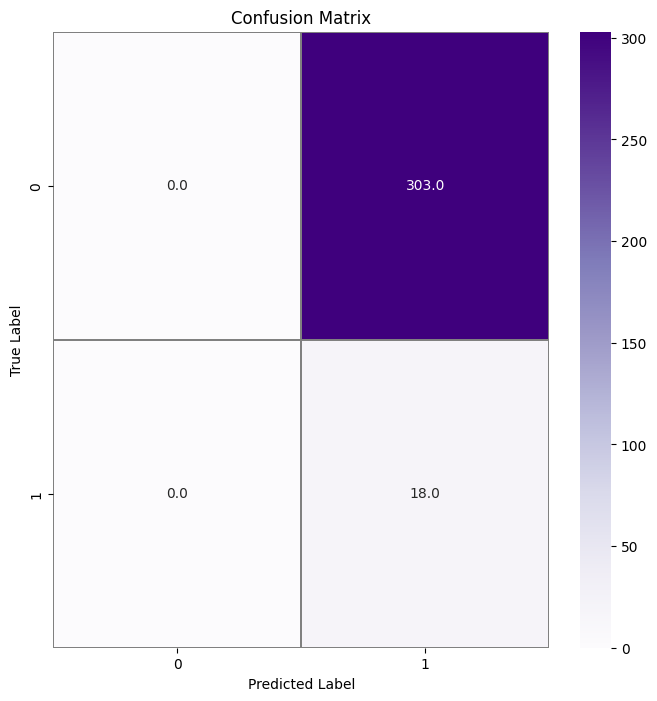

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.06      1.00      0.11        18

    accuracy                           0.06       321
   macro avg       0.03      0.50      0.05       321
weighted avg       0.00      0.06      0.01       321

         Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  LBW_GLCM_XGBOOST  0.55                     0.11      0.06          1.0  \

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.06  NaN  1.0  NaN  


/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

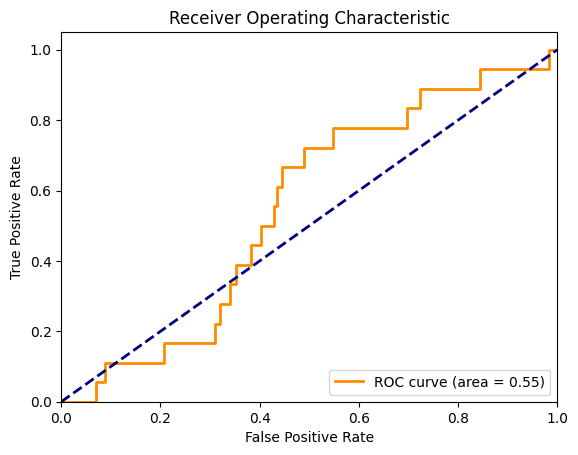

In [16]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name=model_name)

# LOGISTIC REGRESSION

In [17]:
model_name = 'LBW_GLCM_LR'

In [18]:
classifier = LogisticRegression(random_state=42, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.048648648648648596,
                                 1: 0.9513513513513514},
                   random_state=42)

Best threshold: 0.55 with F1-score: 0.15


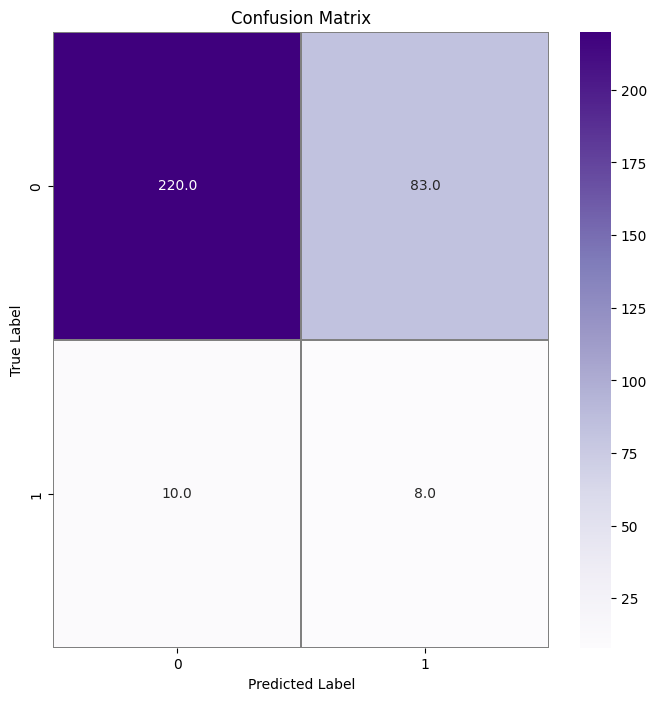

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       303
           1       0.09      0.44      0.15        18

    accuracy                           0.71       321
   macro avg       0.52      0.59      0.49       321
weighted avg       0.91      0.71      0.79       321

    Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  LBW_GLCM_LR  0.6                     0.15      0.71         0.44  \

   Specificity   PPV   NPV   PLR   NLR  
0         0.73  0.09  0.96  1.62  0.77  


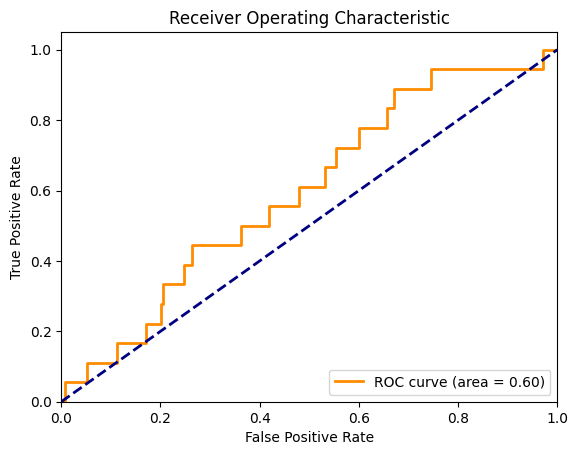

In [19]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name=model_name)